In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
data =  pd.read_csv('magic04.data', sep=",")

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [7]:
X = np.array(data.values[:,:-1])
X[0:5]

array([[28.7967, 16.0021, 2.6449, 0.3918, 0.1982, 27.7004, 22.011,
        -8.2027, 40.092, 81.8828],
       [31.6036, 11.7235, 2.5185, 0.5303, 0.3773, 26.2722, 23.8238,
        -9.9574, 6.3609, 205.261],
       [162.05200000000002, 136.031, 4.0612, 0.0374, 0.0187, 116.741,
        -64.858, -45.216, 76.96, 256.788],
       [23.8172, 9.5728, 2.3385, 0.6147, 0.3922, 27.2107, -6.4633,
        -7.1513, 10.449000000000002, 116.73700000000001],
       [75.1362, 30.9205, 3.1611, 0.3168, 0.1832, -5.5277, 28.5525,
        21.8393, 4.648, 356.462]], dtype=object)

In [8]:
X = StandardScaler().fit_transform(X)
y = np.array(data.values[:,-1])
y[y=='g']=0
y[y=='h']=1


In [9]:
X = np.array(X)
y = np.array(y)
print(y)
print(X)

[0 0 0 ... 1 1 1]
[[-0.57722602 -0.33680419 -0.38113037 ... -0.40584194  0.47681587
  -1.49786555]
 [-0.51096889 -0.57002666 -0.64859479 ... -0.49009359 -0.81541816
   0.15312459]
 [ 2.56827756  6.20585836  2.61578306 ... -2.18302986  1.88922413
   0.84263513]
 ...
 [ 0.52392318  1.38177927  1.31887687 ... -0.4665087   0.10163583
   0.83900338]
 [ 1.58775746  2.98278123  2.47337518 ... -3.07720555  2.18525981
   2.87032093]
 [ 3.16145936  1.67999288  0.81314905 ...  1.49930076  0.96101431
   1.05044239]]


In [10]:
print(sum(y[0:12332]))
x_neg = X[:12332]
np.random.shuffle(x_neg)

0


In [11]:
x_test=x_neg[0:6166]
x_neg_train = x_neg[6166:]
x_pos_train = X[12332:]
x_train = np.concatenate((x_neg_train,x_pos_train))
np.random.shuffle(x_test)
y_train=y[6166:19020].reshape(-1,1).astype(int)
y_test=y[0:6166].reshape(-1,1).astype(float)

In [12]:
fpr_values_kraska = []
size_values_kraska = []

# Kraska Hash Model

In [13]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [14]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

In [15]:
print(y_train)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Number of nodes: 1


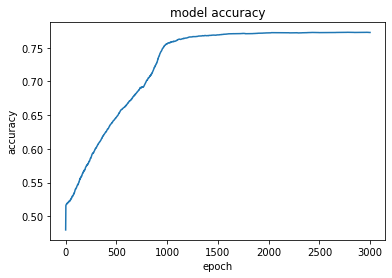

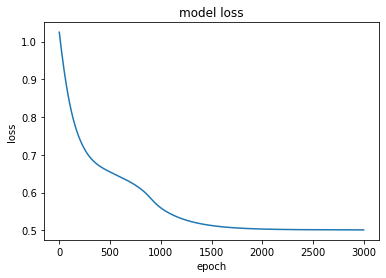

Size: 833.000000 bits - FPR: 0.994324 



Number of nodes: 3


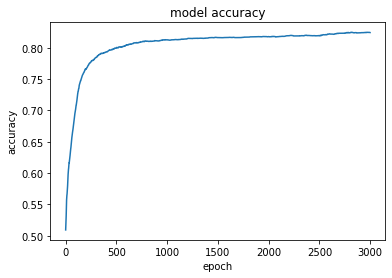

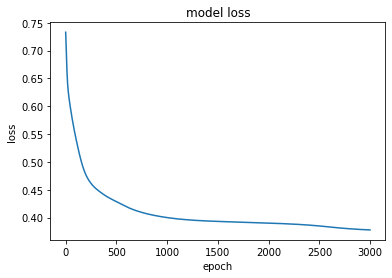

Size: 2369.000000 bits - FPR: 0.781868 



Number of nodes: 5


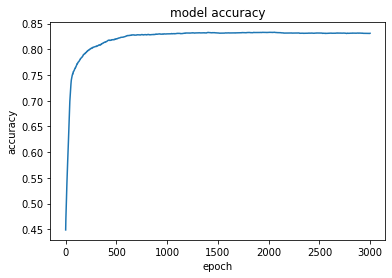

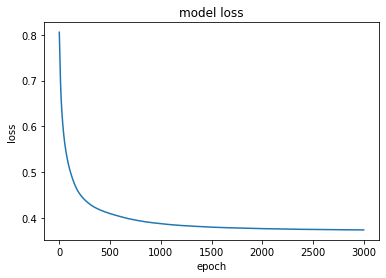

Size: 3905.000000 bits - FPR: 0.661531 



Number of nodes: 7


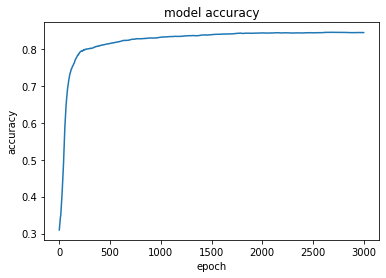

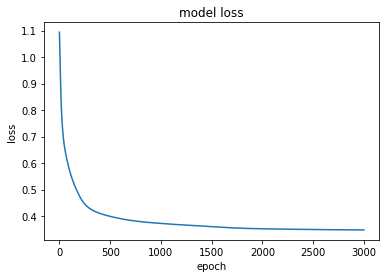

Size: 5441.000000 bits - FPR: 0.518651 



Number of nodes: 9


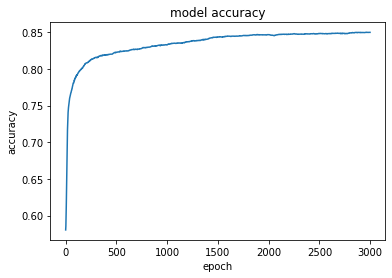

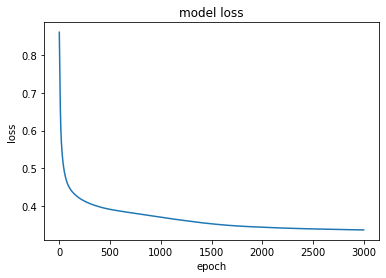

Size: 6977.000000 bits - FPR: 0.419072 



Number of nodes: 11


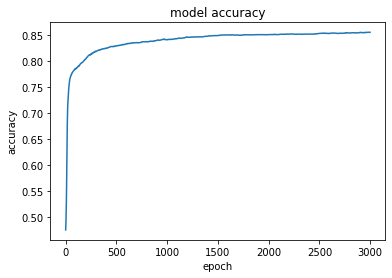

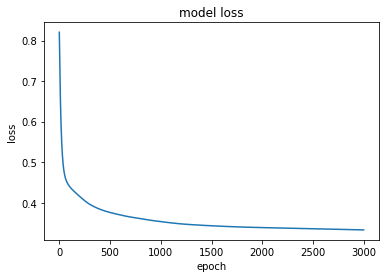

Size: 8513.000000 bits - FPR: 0.376743 



Number of nodes: 13


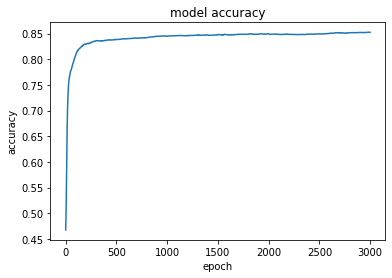

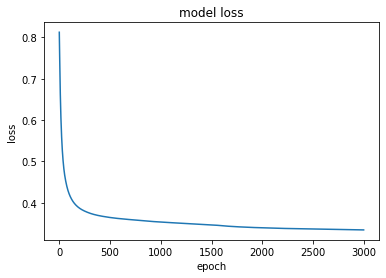

Size: 10049.000000 bits - FPR: 0.322089 



Number of nodes: 15


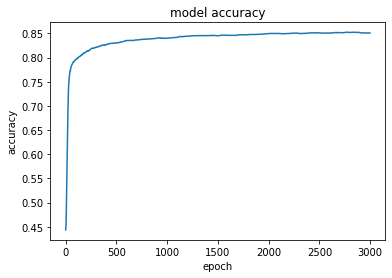

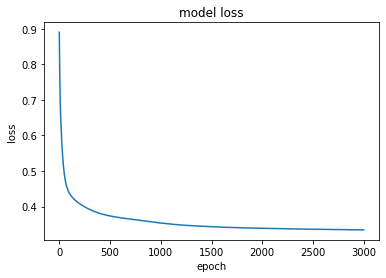

Size: 11585.000000 bits - FPR: 0.294356 



Number of nodes: 17


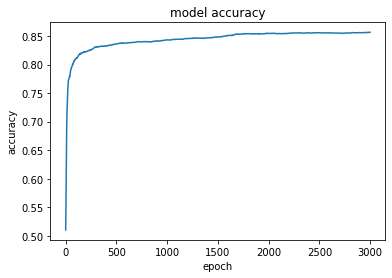

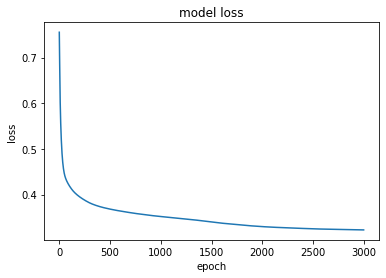

Size: 13121.000000 bits - FPR: 0.259812 



Number of nodes: 19


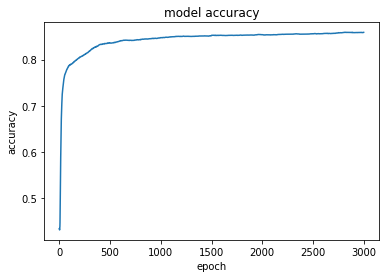

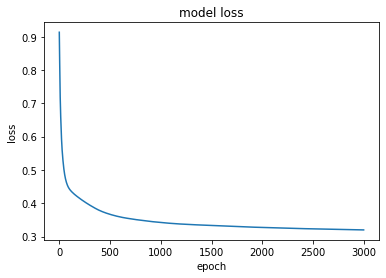

Size: 14657.000000 bits - FPR: 0.228349 



Number of nodes: 21


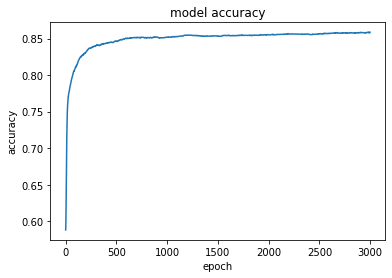

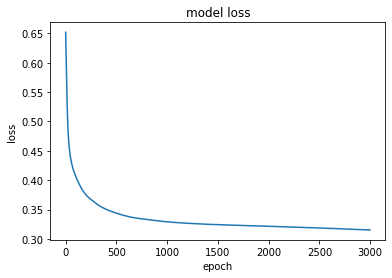

Size: 16193.000000 bits - FPR: 0.210185 



Number of nodes: 23


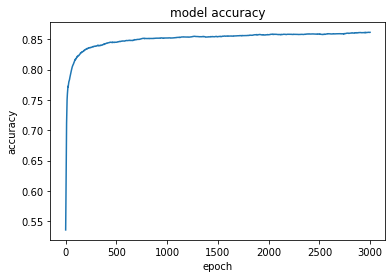

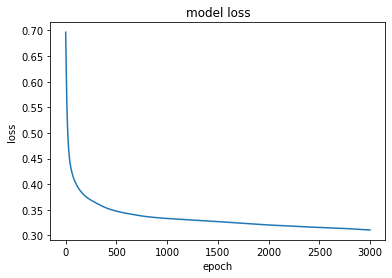

Size: 17729.000000 bits - FPR: 0.182939 



Number of nodes: 25


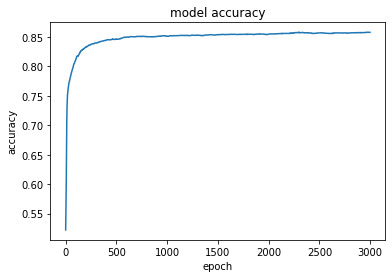

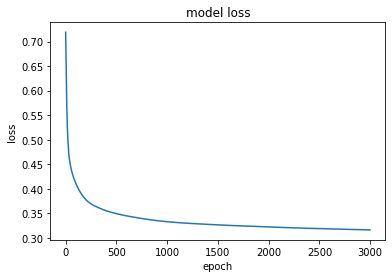

Size: 19265.000000 bits - FPR: 0.193480 



Number of nodes: 27


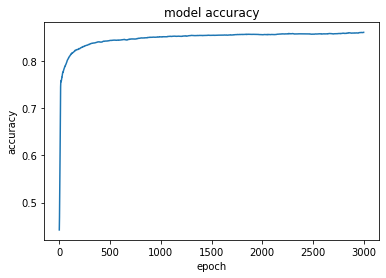

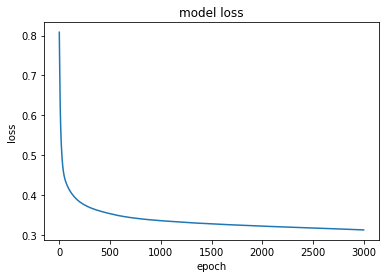

Size: 20801.000000 bits - FPR: 0.168018 



Number of nodes: 29


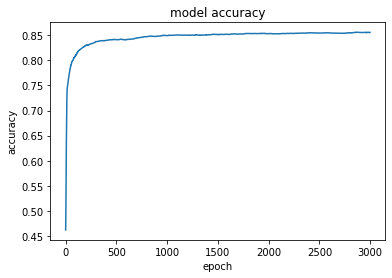

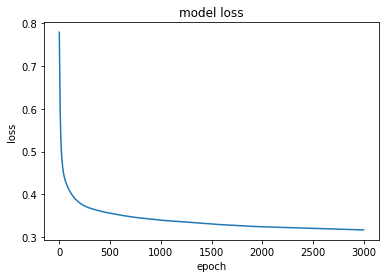

Size: 22337.000000 bits - FPR: 0.156828 



Number of nodes: 31


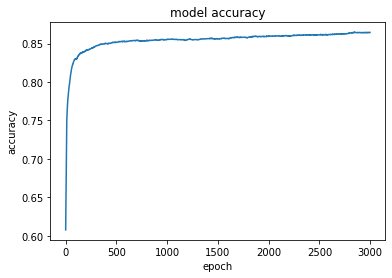

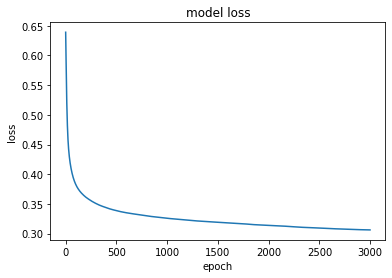

Size: 23873.000000 bits - FPR: 0.140934 



Number of nodes: 33


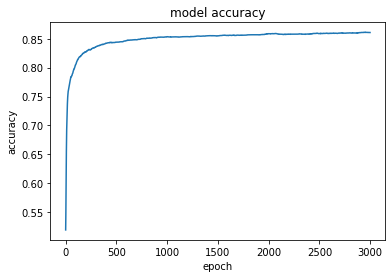

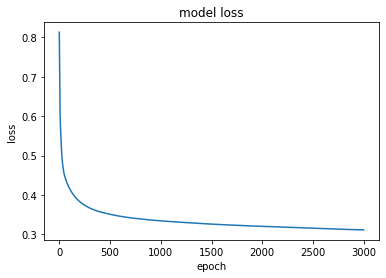

Size: 25409.000000 bits - FPR: 0.144016 



Number of nodes: 35


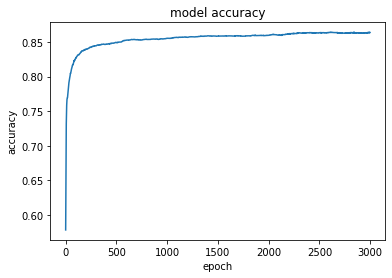

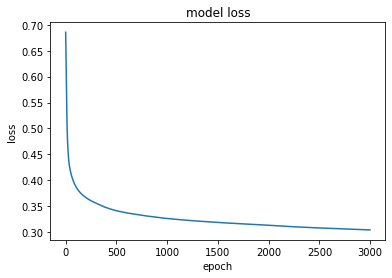

Size: 26945.000000 bits - FPR: 0.131852 



Number of nodes: 37


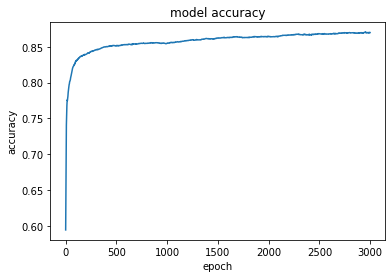

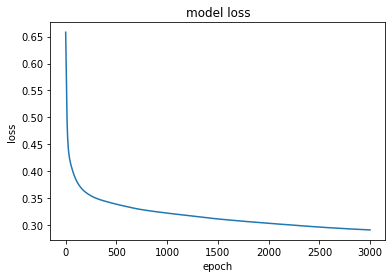

Size: 28481.000000 bits - FPR: 0.118067 



Number of nodes: 39


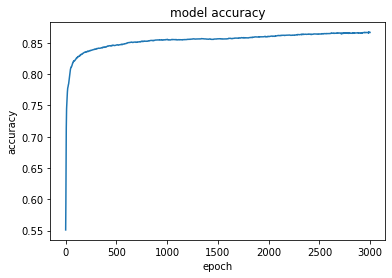

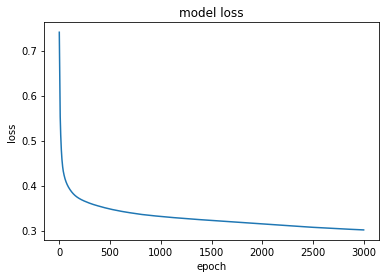

Size: 30017.000000 bits - FPR: 0.113526 



Number of nodes: 41


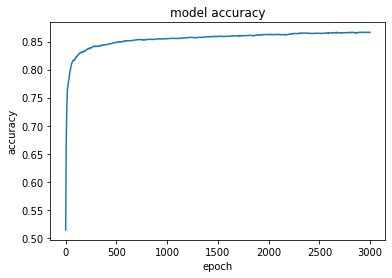

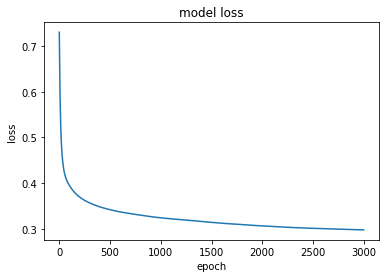

Size: 31553.000000 bits - FPR: 0.112228 



Number of nodes: 43


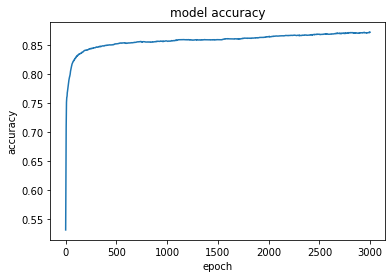

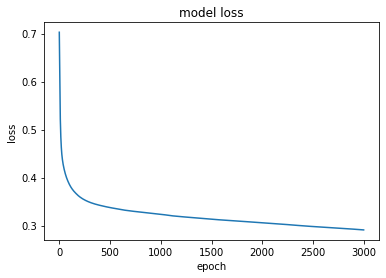

Size: 33089.000000 bits - FPR: 0.109471 



Number of nodes: 45


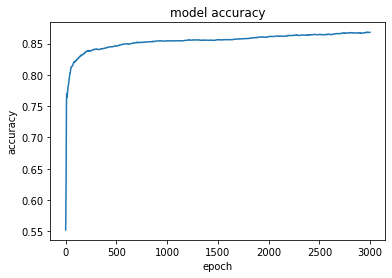

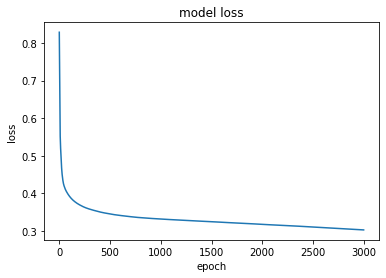

Size: 34625.000000 bits - FPR: 0.106714 





In [16]:
get_data_points_Kraska(x_train,y_train,x_test,y_test,1,2,23,3000,fpr_values_kraska,size_values_kraska)

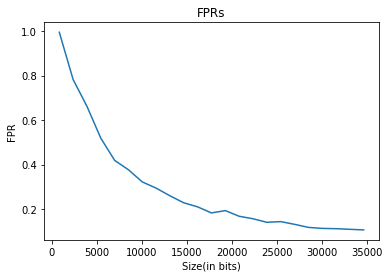

In [17]:
plt.plot(size_values_kraska,fpr_values_kraska)
plt.title('FPRs')
plt.xlabel('Size(in bits)')
plt.ylabel('FPR')
plt.show()

# Projection model

In [18]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [19]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [20]:
fpr_values = []
size_values = []

In [21]:
get_data_points_Projection(x_train,x_test,y_train,800,200,200,100,fpr_values,size_values)

(6688, 10)
Size: 800 Bits - FPR: 0.956536 



Size: 1000 Bits - FPR: 0.931398 



Size: 1200 Bits - FPR: 0.966753 



Size: 1400 Bits - FPR: 0.912261 



Size: 1600 Bits - FPR: 0.947940 



Size: 1800 Bits - FPR: 0.908855 



Size: 2000 Bits - FPR: 0.891177 



Size: 2200 Bits - FPR: 0.907882 



Size: 2400 Bits - FPR: 0.869121 



Size: 2600 Bits - FPR: 0.871067 



Size: 2800 Bits - FPR: 0.859552 



Size: 3000 Bits - FPR: 0.831495 



Size: 3200 Bits - FPR: 0.816413 



Size: 3400 Bits - FPR: 0.809601 



Size: 3600 Bits - FPR: 0.808466 



Size: 3800 Bits - FPR: 0.771164 



Size: 4000 Bits - FPR: 0.752189 



Size: 4200 Bits - FPR: 0.755757 



Size: 4400 Bits - FPR: 0.719591 



Size: 4600 Bits - FPR: 0.703373 



Size: 4800 Bits - FPR: 0.713591 



Size: 5000 Bits - FPR: 0.701427 



Size: 5200 Bits - FPR: 0.649692 



Size: 5400 Bits - FPR: 0.675641 



Size: 5600 Bits - FPR: 0.675641 



Size: 5800 Bits - FPR: 0.664450 



Size: 6000 Bits - FPR: 0.622608 



Size: 6200 Bits - 

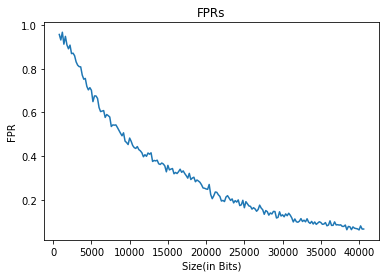

In [22]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# Normal Bloom Filter Values

In [23]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [24]:
print(sum(y_train))
print(len(y_train))

[6688]
12854


In [25]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values]

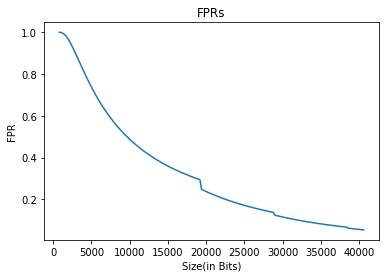

In [26]:
plt.plot(size_values,y_ideal)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter


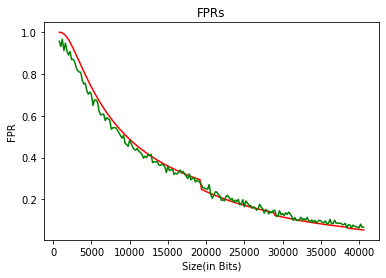

In [27]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model

#  FPR Comparison between Kraska Hash Model, Projection Model and Normal Bloom Filter

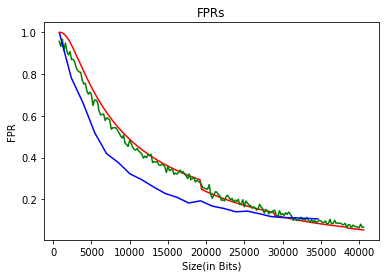

In [28]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.plot(size_values_kraska,fpr_values_kraska,color='blue')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model
# Blue- Kraska Hash Model